<a href="https://colab.research.google.com/github/Ald-00/Ald-00/blob/main/SET3125_Electrical_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SET 3125 Project Outline ---- DC-OPF





## Background of the Project


The goal of this project is to develop a machine learning model **to predict the results of a DC Optimal Power Flow (DC-OPF) for a 14-bus power system**. You need to train a supervised learning regression model using historical data generated from DC-OPF solutions (provided already). By doing so, we aim to create a fast and reliable model that can be used in real-time operations, bypassing the need for computationally expensive optimization solvers.

The **features** of the dataset are the power demands at different buses while the **labels** are the generator set points that satisfy the optimal power flow conditions.

In the following, we provide some background information for DC-OPF, such that you may have a better understanding of the problem.

### DC-OPF Formulation

DC Optimal Power Flow (DC-OPF) is a linearized version of the (AC) Optimal Power Flow problem that is used to determine the optimal operating points of generators in a power system in terms of minimizing generation costs while meeting load demands and adhering to system constraints. The DC-OPF formulation involves:

1. **Objective Function**: Minimize the total cost of power generation.
  
   $$\min_{P_{G_i}} \quad \sum_{i \in N} C(P_{G_i})=aP_{G_i}$$
   Where $ C(P_{G_i})$ is the cost function associated with the power generated by generator $G_i$. The objective is to minimize the total generation cost while ensuring the system operates reliably. Note that if there is no generator connected on bus $i$, then $P_{G_i}=0$.

2. **Power Balance Equation**: At each bus, the generated power minus the load demand must be balanced by the net power flow into or out of the bus.
   
   $$
   \sum_{(i,j)\in L}F_{ij} = P_{G_i} - P_{D_i}, \quad \forall i \in N
  $$
   
   Here, $F_{ij}$ represents the power flow from bus $i$ to bus $j$ through transmission line $ij$ (*positive* means flows out). $P_{D_i}$ represents the load demand at bus $i$.

3. **Power Flow Equations**: Power flow between buses is modeled as a linear function of the voltage angle difference between buses:
   
   $$
   F_{ij} = B_{ij} (	\theta_i - 	\theta_j), \quad \forall (i, j) \in L
   $$
   
   Where $ B_{ij} $ is the susceptance of the line between bus $ i $ and bus $ j $, and $ 	\theta_i - 	\theta_j $ represents the voltage angle difference. This equation is used to calculate the power flowing on the transmission lines.

4. **Flow Limits**: Each transmission line has a power flow limit that must not be exceeded to ensure system security:
   
   $$
   F_{ij}^{	\text{min}}\leq F_{ij} \leq F_{ij}^{	\text{max}}, \quad \forall (i, j) \in L$$

## Basic Workflow with Fully Connected Neural Network (FNN)





### 0. Import and install necessary libraries

In [ ]:
!pip install torch-geometric
!pip install gurobipy
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 54.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch_geometric.utils as utils
import matplotlib
import networkx as nx
import math
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import ChebConv, GraphConv, GCNConv
from torch.nn import Linear
from torch.nn import Parameter
from itertools import product
import gurobipy as gp
from gurobipy import GRB

### 1. Dataset loading, inspection, and preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Load the dataset by inserting your file directory
load_demand = np.load('/content/drive/MyDrive/MLW for DES Project/load_demands.npy')
generator_supply = np.load('/content/drive/MyDrive/MLW for DES Project/generator_supplies.npy')

### Task 1


*   check the distributions of the load demands and gnerator supplies, are there outliers? Comment on how you would remove them if any
*   Look at the total demand for each data sample each sample, does it match total supply?



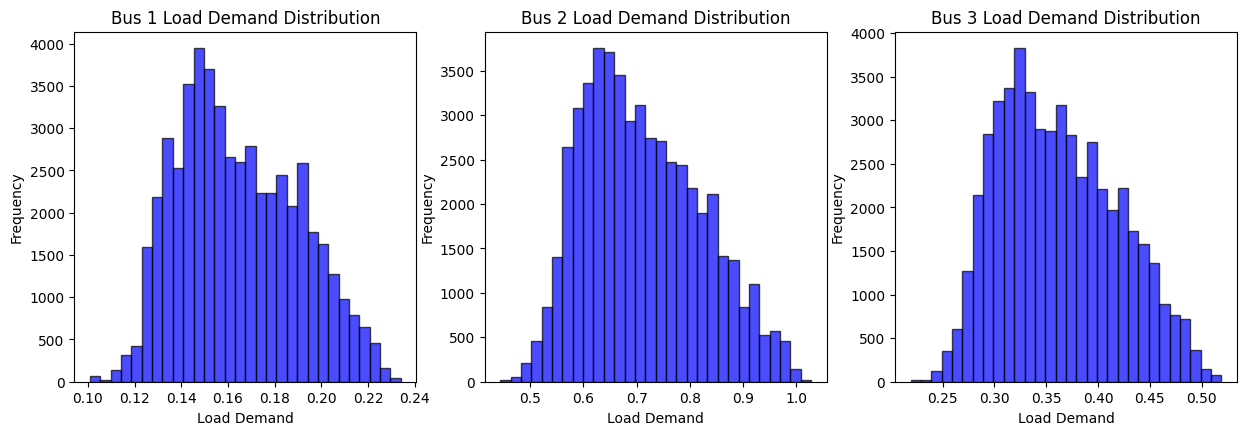

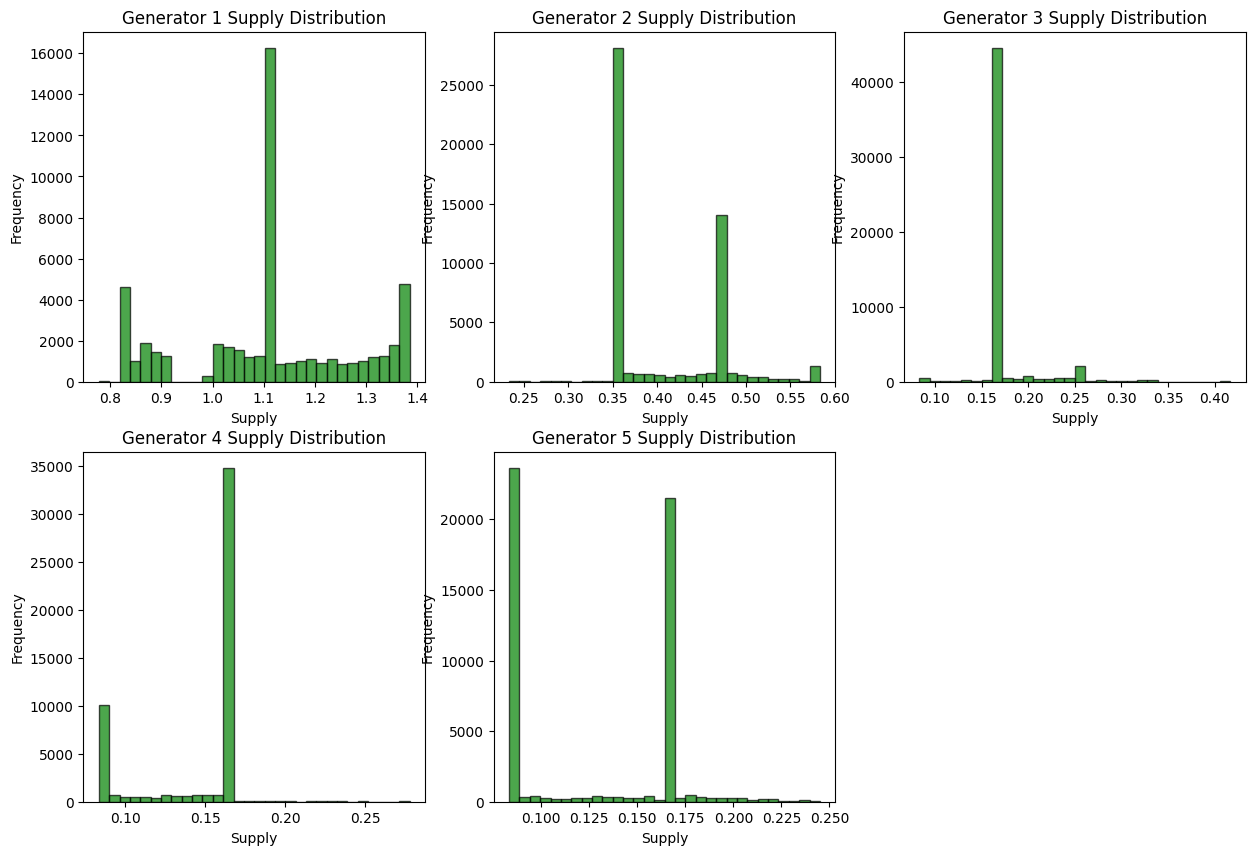

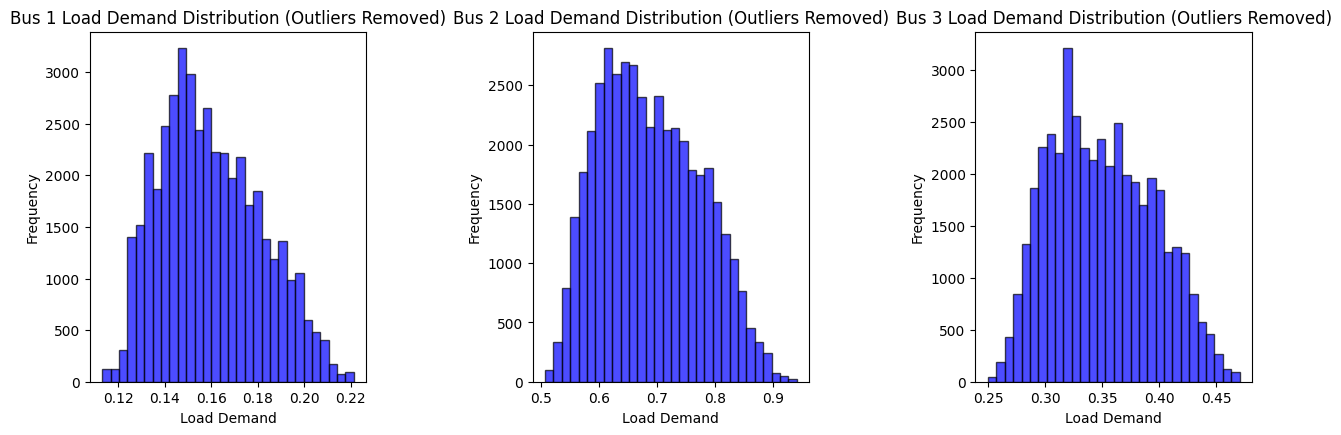

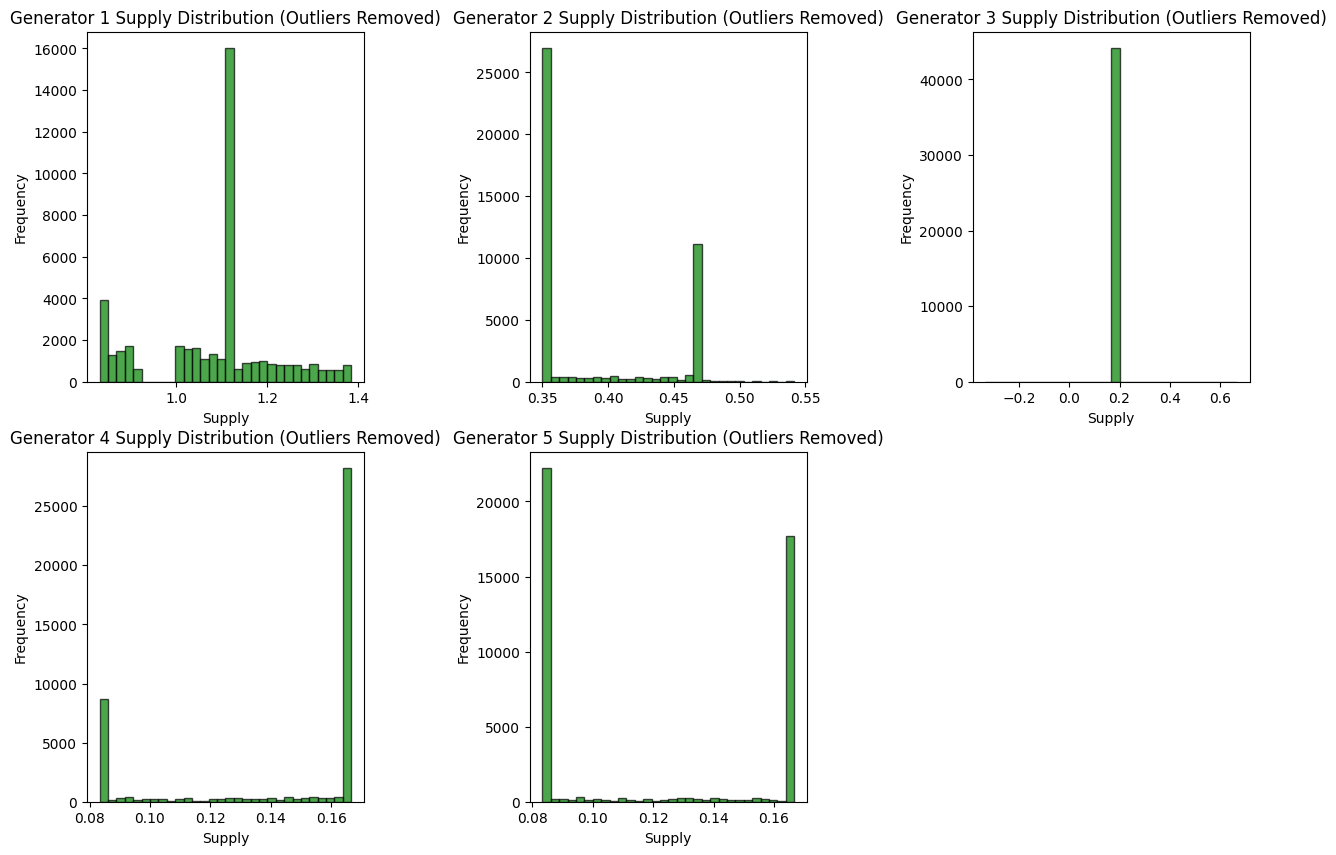

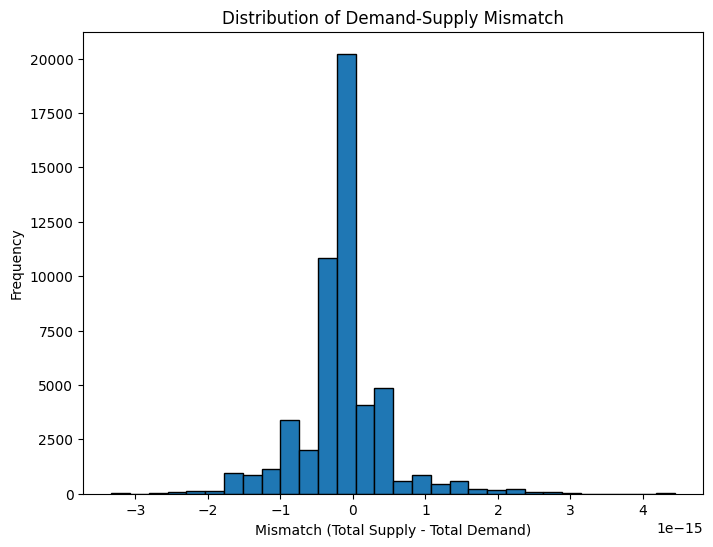

Maximum Mismatch: 4.440892098500626e-15
Mean Mismatch: -1.5275381752174615e-16


In [ ]:
#1) Load Demand and Generator Supply Distributions

#Load demand distributions
plt.figure(figsize=(15, 10))
for i in range(1, 4):  #Plot for buses 1, 2, 3
    plt.subplot(2,3,i)
    plt.hist(load_demand[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Bus {i} Load Demand Distribution')
    plt.xlabel('Load Demand')
    plt.ylabel('Frequency')

#Generator supply distributions
plt.figure(figsize=(15, 10))
num_generators = generator_supply.shape[1]  #Get the number of generators from the shape of generator_supply
num_rows = 2
num_cols = 3
for i in range(num_generators):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(generator_supply[:, i], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.title(f'Generator {i + 1} Supply Distribution')
    plt.xlabel('Supply')
    plt.ylabel('Frequency')
plt.show()

#2)Outlier Detection and Removal using IQR method

def remove_outliers_iqr(data): #Function to apply to both load and gen (return indices of inliers instead of filtered data)
    k = 3
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    inlier_indices = np.where((data >= lower_bound) & (data <= upper_bound))[0]
    return inlier_indices

#Loads
#load_demand outlier removal
inlier_indices_load = []
for i in range(1, 4):  #For buses 1, 2, 3
    indices = remove_outliers_iqr(load_demand[:, i])
    inlier_indices_load.append(indices)

#Find common inliers for load_demand
common_inliers_load = inlier_indices_load[0]
for indices in inlier_indices_load[1:]:
    common_inliers_load = np.intersect1d(common_inliers_load, indices)

#Filter load_demand data (creating a new filtered variable)
filtered_load_demand = load_demand[common_inliers_load]

#Generators
#Apply outlier removal to generator_supply and filter
filtered_generator_supply = generator_supply.copy()
all_inlier_indices_gen = np.arange(generator_supply.shape[0])

for i in range(generator_supply.shape[1]):
    inlier_indices = remove_outliers_iqr(generator_supply[:, i])
    all_inlier_indices_gen = np.intersect1d(all_inlier_indices_gen, inlier_indices)  #Update all_inlier_indices_gen to keep only common inliers

#Filtering both datasets using all_inlier_indices_gen
filtered_generator_supply = filtered_generator_supply[all_inlier_indices_gen]
filtered_load_demand = filtered_load_demand[all_inlier_indices_gen]  #Filter load_demand accordingly

#Load demand distributions with outliers removed
plt.figure(figsize=(15, 10))
for i in range(1, 4):  #Plot for buses 1, 2, 3
    plt.subplot(2, 3, i)
    plt.hist(filtered_load_demand[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Bus {i} Load Demand Distribution (Outliers Removed)')
    plt.xlabel('Load Demand')
    plt.ylabel('Frequency')
plt.subplots_adjust(wspace=0.6, hspace=0.2)
plt.show()

#Generator supply with outliers removed
plt.figure(figsize=(15, 10))
num_generators = filtered_generator_supply.shape[1]
num_rows = 2
num_cols = 3
total_subplots = num_rows * num_cols

#Check if num_generators exceeds the total number of subplots
if num_generators > total_subplots:
    num_cols = math.ceil(num_generators / num_rows)
    total_subplots = num_rows * num_cols

for i in range(num_generators):
    plt.subplot(num_rows, num_cols, i + 1) #Start indexing from 1 (not 4)
    plt.hist(filtered_generator_supply[:, i], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.title(f'Generator {i + 1} Supply Distribution (Outliers Removed)')
    plt.xlabel('Supply')
    plt.ylabel('Frequency')
plt.subplots_adjust(wspace=0.6, hspace=0.2)
plt.show()

#3) Total Demand vs. Total Supply

total_demand = np.sum(load_demand, axis=1)  #Sum across buses for each sample
total_supply = np.sum(generator_supply, axis=1)  #Sum across generators for each sample

mismatch = total_supply - total_demand

plt.figure(figsize=(8, 6))
plt.hist(mismatch, bins=30, edgecolor='black')
plt.title('Distribution of Demand-Supply Mismatch')
plt.xlabel('Mismatch (Total Supply - Total Demand)')
plt.ylabel('Frequency')
plt.show()

print("Maximum Mismatch:", np.max(np.abs(mismatch)))
print("Mean Mismatch:", np.mean(mismatch))

In [ ]:
if torch.cuda.is_available():
  print("Training on GPU")
  device = torch.device("cuda:0")
else:
  print("Training on CPU")
  device = torch.device("cpu")

Training on GPU


### 2. Model definition

A tutorial on defining a NN with torch: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#

In [ ]:
# Define the model, e.g., with torch write a simple feedforward network
class FF_DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,num_layers):
        super(FF_DNN, self).__init__()
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim=hidden_dim

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for _ in range(num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):

        out = self.model(x)
        return out

### 3. Functions

- dataset spliting function
- loss function
- training function (train)
- validation function (eval)
- test function (test)
- Hyperparameter multiple run function

In [ ]:
# dataset splitting function, we use ratio [66.6:16.6:16.6]
def split_data(x_data,y_data):

  train_size = int((x_data.shape[0]//3) * 2)
  val_size = int((x_data.shape[0]//3) / 2)
  test_size = int((x_data.shape[0]//3) / 2)

  train_x = x_data[:train_size,:]
  val_x = x_data[train_size:train_size+val_size,:]
  test_x = x_data[train_size+val_size:,:]

  train_y = y_data[:train_size,:]
  val_y = y_data[train_size:train_size+val_size,:]
  test_y = y_data[train_size+val_size:,:]

  return train_x, val_x, test_x , train_y, val_y, test_y

In [ ]:
# we define a simple loss function
def simple_loss(y_pred, y):
  loss_fn = nn.MSELoss()
  loss = loss_fn(y_pred, y)
  return loss

In [ ]:
# model training function
def train_fnn(model, loader, criterion, optimizer, device='cpu'):
    model.to(device)
    model.train() # specifies that the model is in training mode

    epoch_loss = 0
    model.train()
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [ ]:
# model evaluation function
@torch.no_grad()
def evaluate_fnn(model, loader, criterion, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [ ]:
# model testing function

def test_fnn(model, loader, criterion, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode
    epoch_loss = 0
    model.eval()

    model_preds = []
    actual_y = []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            model_preds.append(y_pred)
            actual_y.append(y)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()


    return epoch_loss / len(loader), model_preds,actual_y

In [ ]:
# simple  function to create multiple run instances of model training for best hyperparameter selection

def create_hyper_combination_FNN(h_feat, l_feat):
    parameters = dict(
      hid_features= h_feat,
      num_layers= l_feat
  )

    param_values = [v for v in parameters.values()]
    print(param_values)

    for  hid_features, num_layers in product(*param_values):
        print(hid_features, num_layers)

    return param_values

### 4. Training setup

Execute dataset split and specify batchsize.



In [ ]:
# Convert data to torch tensors and split the dataset
x_data = torch.tensor(load_demand).float()
y_data = torch.tensor(generator_supply).float()

train_x, val_x, test_x , train_y, val_y, test_y = split_data(x_data, y_data)
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#### Here is an example standard FNN model training. We:

- perform the loop over a specified number of epochs
- optimiser setup
- NN model instantiation
- Print output / plot training progress

In [ ]:
# specify the model input and output dimensions
N_input_features = 14
N_output_features = 5

Epoch: 0
	Train Loss: 0.016
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.001
	 Val. Loss: 0.001
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000


[]

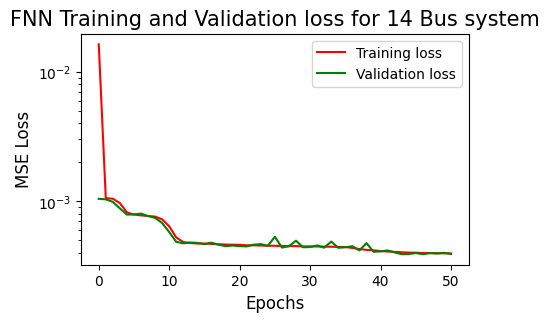

In [ ]:
# create a model instance and train model for one run, model hyperparameters are fixed as 16 and 4 here
model = FF_DNN(N_input_features, 16, N_output_features,4)

# specify optimizer and other model details
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

training_losses = []
validation_losses = []
best_valid_loss = float('inf')
early_stop_thresh = 20
epochs = 50
best_epoch = -1
for epoch in range(epochs+1):
  train_loss = train_fnn(model, train_loader, simple_loss, optimizer)
  valid_loss = evaluate_fnn(model, val_loader, simple_loss)
  training_losses.append(train_loss)
  validation_losses.append(valid_loss)


  scheduler.step(valid_loss)

  if epoch % 10 == 0:
      print(f'Epoch: {epoch}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f}')
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss

training_losses=np.array(training_losses)
validation_losses=np.array(validation_losses)

plt.subplots(figsize=(5,3))
plt.plot([i for i in range(len(training_losses))], training_losses, 'r', label='Training loss')
plt.plot([i for i in range(len(validation_losses))], validation_losses, 'g', label='Validation loss')
plt.legend()
plt.title(f'FNN Training and Validation loss for 14 Bus system',fontsize = 15)
plt.xlabel('Epochs',fontsize = 12)
plt.ylabel('MSE Loss',fontsize = 12)
plt.semilogy()

### 5. Training with hyperparameter combinations

### Task 5



1.   Use the different hyperparameter combinations we have provided with 'create_hyper_combination_FNN' function above to create 6 runs

2.   Comment on the influence of model hyperparameters on the model accuracy

3. Use the model with the best hyperparameter combination for subsequent evaluations





In [ ]:

h_feat = [32, 64]
l_feat = [2, 3, 4]

#specify the hyperparameter selections
param_values = create_hyper_combination_FNN(h_feat, l_feat)

trained_models = []

for run_number, (hidden_dim, num_layers) in enumerate(product(*param_values)):
    print("Run number:", run_number + 1)

    #Create model instance with current hyperparameters
    model = FF_DNN(N_input_features, hidden_dim, N_output_features, num_layers)

    #Specify optimizer and other details
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    #Training loop
    training_losses = []
    validation_losses = []
    best_valid_loss = float('inf')
    epochs = 50

    for epoch in range(epochs + 1):
        train_loss = train_fnn(model, train_loader, simple_loss, optimizer)
        valid_loss = evaluate_fnn(model, val_loader, simple_loss)
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        scheduler.step(valid_loss)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}')
            print(f'\tTrain Loss: {train_loss:.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f}')
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss

    #Evaluate on test set
    test_loss, model_preds, actual_y = test_fnn(model, test_loader, simple_loss)
    print("Test loss:", np.array(test_loss))

    trained_models.append(model)  #Store the trained model

print('Finished all runs with different hyperparameters!')

[[32, 64], [2, 3, 4]]
32 2
32 3
32 4
64 2
64 3
64 4
Run number: 1
Epoch: 0
	Train Loss: 0.005
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000
Test loss: 0.0003319581808622005
Run number: 2
Epoch: 0
	Train Loss: 0.008
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000
Test loss: 0.0002780674843813939
Run number: 3
Epoch: 0
	Train Loss: 0.006
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.00

Increasing the number of hidden features from 32 to 64 generally improved the model's accuracy, indicating that the model benefits from more capacity.
The best performance was achieved with 64 hidden features and 3 layers, suggesting a good balance between model complexity and generalization.

In [ ]:
trained_models = []
test_losses = []  #List to store test losses

for run_number, (hidden_dim,num_layers) in enumerate(product(*param_values)):
  print("run number:", run_number + 1)

  #create simple model instance
  model = FF_DNN(N_input_features, hidden_dim, N_output_features,num_layers)

  #specify optimizer and other model details
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-5)
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)


  training_losses = []
  validation_losses = []
  best_valid_loss = float('inf')
  early_stop_thresh = 20
  epochs = 50
  best_epoch = -1

  for epoch in range(epochs+1):
    train_loss = train_fnn(model, train_loader, simple_loss, optimizer)
    valid_loss = evaluate_fnn(model, val_loader, simple_loss)
    training_losses.append(train_loss)
    validation_losses.append(valid_loss)

    scheduler.step(valid_loss)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

  test_loss, model_preds,actual_y = test_fnn(model, test_loader, simple_loss)

  trained_models.append(model)
  test_losses.append(test_loss)  #Store the test loss
  print("test loss:", np.array(test_loss))

print('finished all runs with different hyperparameters!')

#Select the best model based on test loss
best_model_index = test_losses.index(min(test_losses))
best_model = trained_models[best_model_index]


run number: 1
Epoch: 0
	Train Loss: 0.006
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.001
	 Val. Loss: 0.001
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000
test loss: 0.0003368754787046232
run number: 2
Epoch: 0
	Train Loss: 0.005
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000
test loss: 0.00023034315462210439
run number: 3
Epoch: 0
	Train Loss: 0.007
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000
test loss: 0.00038345009098718

### 6. Understand predictions

To ensure the model is working as we would expect, perform the following sanity checks:

### Task 6


*   plot an histogram of prediction errors, what type of distribution do you obtain?
*   For the test data, plot the mismatch between the sum of demands and sum of predicted generator supply? What is the maximum mismatch? What is the mean mismatch?



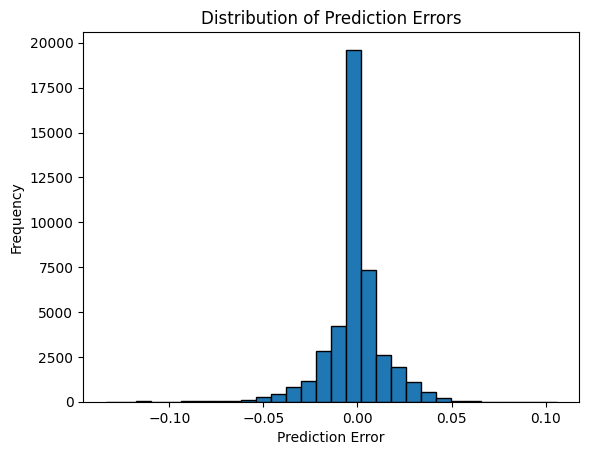

In [ ]:
# Make predictions using the best model
predictions = best_model(test_x)

# Calculate prediction errors
errors = test_y.cpu().numpy() - predictions.cpu().detach().numpy()
# Convert tensors to NumPy arrays for plotting

# Flatten the errors array if it's multi-dimensional
errors = errors.flatten()

# Plot the histogram
plt.hist(errors, bins=30, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

Comment: The resulting is a normal distribution.

In [ ]:
#Function to compute the total power demand minus the total power injection.
def compute_power_balance_mismatch(x, y):
  total_demand = torch.sum(x, dim=1)  #Sum demand across buses
  total_supply = torch.sum(y, dim=1)  #Sum supply across generators
  power_balance_mismatch = total_supply - total_demand  #Mismatch
  return power_balance_mismatch

In [ ]:
# add code to compute the maximum and mean power balance mismatch between the load demand and true generator supply here. HINT - values should be very close to zero
mismatch_true = compute_power_balance_mismatch(torch.tensor(load_demand).float(), torch.tensor(generator_supply).float())  #Calculate mismatch for true values
max_power_balance_error = torch.max(torch.abs(mismatch_true)).item()  #Maximum absolute mismatch
mean_power_balance_error = torch.mean(mismatch_true).item()  #Mean mismatch
print(max_power_balance_error, mean_power_balance_error)

4.76837158203125e-07 7.684270109109548e-09


In [ ]:
# add code to compute the maximum and mean power balance mismatch between the load demand and predicted generator supply here
mismatch_pred = compute_power_balance_mismatch(test_x, best_model(test_x)) #Calculate mismatch for predicted values
max_power_balance_error_pred = torch.max(torch.abs(mismatch_pred)).item()  #Maximum absolute mismatch
mean_power_balance_error_pred = torch.mean(mismatch_pred).item()  #Mean mismatch
print(max_power_balance_error_pred, mean_power_balance_error_pred)

0.16494333744049072 0.0029120738618075848


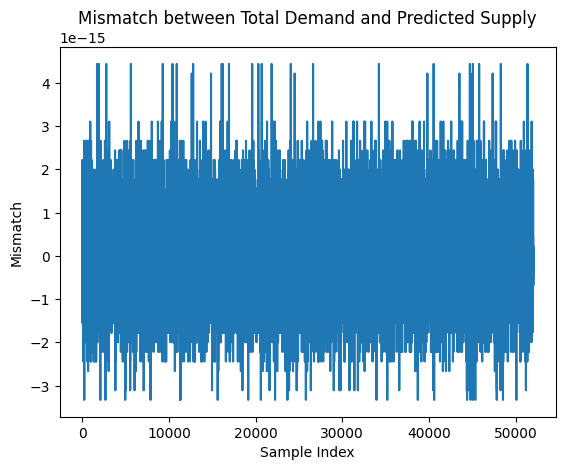

In [ ]:
# add your code for line plot of mismatch here:
plt.plot(mismatch)  #Plot mismatch against sample index
plt.title('Mismatch between Total Demand and Predicted Supply')
plt.xlabel('Sample Index')
plt.ylabel('Mismatch')
plt.show()

## Physics-Informed Training

In this section, we will investigate how we can include physics in the training process and how it affects the training performance.


### 1. The underlying physics

We have seen how much the previous model obeys the underlying physics, which requires that the sum of total demand should match the sum of total supply. Now we would define a physics loss to improve the satisfaction of the power balance constraint.

In [ ]:
# we define a weight for physics loss here

physics_loss_weight = 0.1

### Task 1

Write the physics informed loss function using the power balance mismatch function provided

In [ ]:
def extra_loss(x, y_pred): #Calculates the physics-informed loss based on total power balance (No data about topology).

  total_demand = torch.sum(x, dim=1)      #Sum demand across all buses
  total_supply = torch.sum(y_pred, dim=1) #Sum supply across all generators

  residual = total_supply - total_demand  #Total power mismatch
  phy_loss = torch.mean(residual**2)      #Mean squared error of the mismatch

  return phy_loss * physics_loss_weight   #Scale by physics loss weight

### 2. Adapt functions

To include the physics in the training process, we adapt the train_epoch and evaluate_epoch functions by adding the physics-informed loss term.

In [ ]:
# adjust the training function to include the physics
def train_fnn_with_physics(model, loader, criterion, extra_loss, optimizer, device='cpu'):
    model.to(device)
    model.train() # specifies that the model is in training mode

    epoch_loss = 0
    model.train()
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        data_loss = criterion(y_pred, y)
        physics_loss = extra_loss(x, y_pred)
        loss = data_loss + physics_loss
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [ ]:
# adjust the evaluation function to include the physics
@torch.no_grad()
def evaluate_fnn_with_physics(model, loader, criterion, extra_loss, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            data_loss = criterion(y_pred, y)
            physics_loss = extra_loss(x, y_pred)
            loss = data_loss + physics_loss
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

### 3. Training

To perform the training, we only need to exchange the training and validation function.

Epoch: 0
	Train Loss: 0.007
	 Val. Loss: 0.001 -- without physics: 0.001
Epoch: 10
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000 -- without physics: 0.000
test loss: 0.00018903179639435762


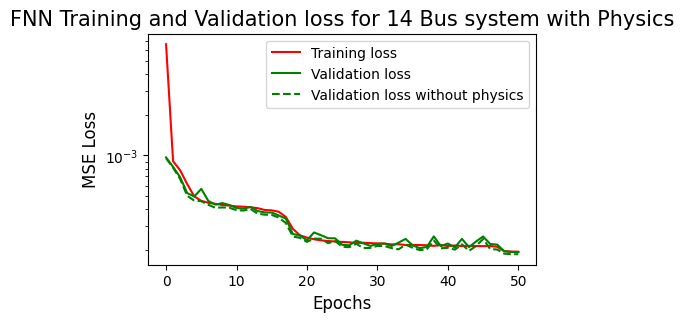

In [ ]:
trained_models_with_physics = []

# Define the hidden_dim and num_layers before using them:
hidden_dim = 64
num_layers = 3

#create simple model instance
model = FF_DNN(N_input_features, hidden_dim, N_output_features, num_layers)

# specify optimizer and other model details
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

training_losses = []
validation_losses = []
validation_losses_without_physics = []
best_valid_loss = float('inf')
early_stop_thresh = 20
epochs = 50
best_epoch = -1
for epoch in range(epochs + 1):
    train_loss = train_fnn_with_physics(model, train_loader, simple_loss, extra_loss, optimizer)
    valid_loss = evaluate_fnn_with_physics(model, val_loader, simple_loss, extra_loss)
    valid_loss_without_physics = evaluate_fnn(model, val_loader, simple_loss)
    training_losses.append(train_loss)
    validation_losses.append(valid_loss)
    validation_losses_without_physics.append(valid_loss_without_physics)

    scheduler.step(valid_loss)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} -- without physics: {valid_loss_without_physics:.3f}')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

training_losses = np.array(training_losses)
validation_losses = np.array(validation_losses)
validation_losses_without_physics = np.array(validation_losses_without_physics)

plt.subplots(figsize=(5, 3))
plt.plot([i for i in range(len(training_losses))], training_losses, 'r', label='Training loss')
plt.plot([i for i in range(len(validation_losses))], validation_losses, 'g', label='Validation loss')
plt.plot([i for i in range(len(validation_losses_without_physics))], validation_losses_without_physics, 'g--', label='Validation loss without physics')
plt.legend()
plt.title(f'FNN Training and Validation loss for 14 Bus system with Physics', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.semilogy()

test_loss, model_preds, actual_y = test_fnn(model, test_loader, simple_loss)

trained_models_with_physics.append(model)
print("test loss:", np.array(test_loss))

### 4. Understand the effect of the physics regularisation

As we did in the previous section, we check again how well the physics are satisfied and the effect on the prediction error distribution.

### Task 4

1.   Check how well the power balance constraint is satisfied now with the physics loss included by computing the maximum and mean power balance mismatches
2.   Plot the error distribution and comment on the type of distribution



In [ ]:
#1)Maximum and mean power balance mismatches
mismatches = []
for batch in test_loader:
    x, _ = batch       #Extract load demand (x)
    y_pred = model(x)  #Get model predictions

    total_demand = torch.sum(x, dim=1)
    total_supply = torch.sum(y_pred, dim=1)
    mismatch = total_supply - total_demand
    mismatches.extend(mismatch.tolist())      #Collect mismatches

max_mismatch = max(abs(m) for m in mismatches)
mean_mismatch = np.mean(mismatches)

print(f"Maximum Power Balance Mismatch: {max_mismatch}")
print(f"Mean Power Balance Mismatch: {mean_mismatch}")

Maximum Power Balance Mismatch: 0.06398570537567139
Mean Power Balance Mismatch: 1.7061554637782247e-05


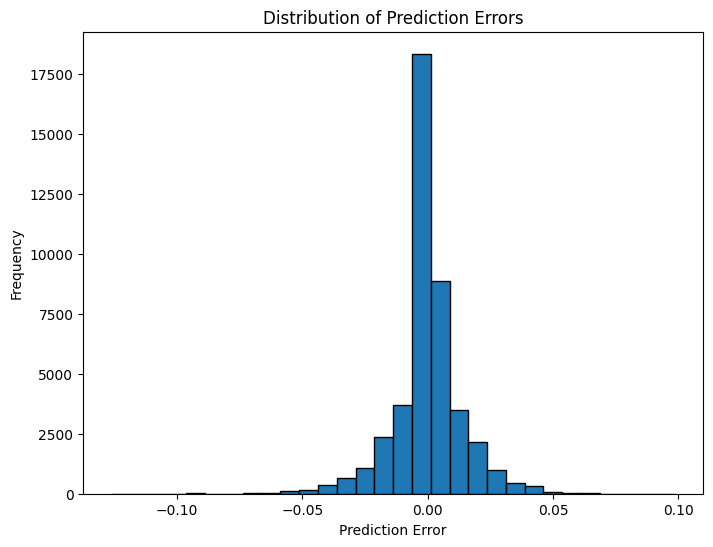

In [ ]:
#2)Error distribution
#Calculation
errors = []
for pred, actual in zip(model_preds, actual_y):
    error = actual - pred
    errors.extend(error.cpu().detach().numpy().flatten())  #Convert to NumPy and flatten

errors = np.array(errors)  #Convert to a NumPy array

#Plotting
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

Comment: The resulting is a normal distribution.

## GNN Training



### 1. Load network topology data and create graph

In [ ]:
# insert file path for the network data file, this is an xlsx file.
data_file = '/content/drive/MyDrive/MLW for DES Project/IEEE_14_bus_Data 1.xlsx'

In [ ]:
# first we need to import the network data to understand how the power grid graph looks like

def read_data(File='IEEE_14_bus_Data.xlsx',print_data=False,DemFactor=1.0,LineLimit=1.0):
    # read the data file and convert it into a dictionary of dataframes

    Sbase=100

    data={}

    Bus=pd.read_excel(File,sheet_name='Bus',skiprows=0,index_col=[0],usecols='A')
    Bus=list(Bus.index)

    branch=pd.read_excel(File,sheet_name='Branch',skiprows=1,index_col=[0,1,2],usecols='A:F')
    line=pd.read_excel(File,sheet_name='Branch',skiprows=1,index_col=0,usecols='A')
    line=list(line.index)

    branch['limit']=(LineLimit*branch['limit'])/Sbase

    br_list=list(branch.index)
    Lines=gp.tuplelist(br_list)

    data['Bus']=Bus
    data['branch']=branch
    data['Lines']=Lines
    data['line']=line


    return data


In [ ]:
data_x_bus = read_data(File=data_file,DemFactor=1.0,print_data=False)

In [ ]:
# function to build networkx graph from adjacency matrix
def Build_graph(data,weighted=False):

    nodes=data['Bus']
    Lines=data['Lines']

    node_list=nodes.copy()

    graph=nx.Graph()

    if weighted==False:
        edge_list=[]
        for l,i,j in Lines:
            graph.add_edge(i, j, weight=1)

        graph.add_nodes_from(node_list)

    if weighted==True:
        edge_list=[]
        for l,i,j in Lines:
            graph.add_edge(i, j, weight=data['branch'].loc[(l,i,j)]['x'])

        graph.add_nodes_from(node_list)
        graph.add_edges_from(edge_list)

    return graph

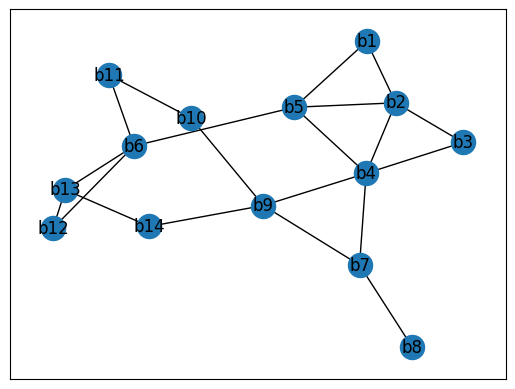

In [ ]:
graph=Build_graph(data_x_bus, weighted=False)
nx.draw_networkx(graph)

### 2. Create GNN Model and Data

In [ ]:
#function to create graph datasets

def create_graph_data(graph,input_x,output_x, edge_list):

    dataset = []
    edge_list = [[edge[0], edge[1]] for edge in edge_list]
    edge_list = torch.tensor(np.array(edge_list).T, dtype=torch.int64)

    for i in range(input_x.shape[0]):
            dataset.append(Data(x=input_x[i].float(), y=output_x[i].float(), edge_index=edge_list))

    return dataset

In [ ]:
## create edge attributes for network
edge_labels = nx.get_edge_attributes(graph, "weight")
edge_list = [i for i in edge_labels.keys() ]

edge_list = [(i[0][1:], i[1][1:]) for i in edge_list]
edge_list = [(int(i[0])-1, int(i[1])-1) for i in edge_list]

In [ ]:
train_dataset = create_graph_data(graph,train_x, train_y,edge_list)
val_dataset = create_graph_data(graph,val_x, val_y,edge_list)
test_dataset = create_graph_data(graph,test_x, test_y,edge_list)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Function to create a simple GNN, the output of convolutional layers are passed through linear layers to get the correct output shape
class VanillaGNN(torch.nn.Module):

    def __init__(self, network_size, num_features, num_of_outputs,conv_hid_features=32, lin_hid_features=256):
        super(VanillaGNN, self).__init__()
        self.network_size = network_size
        self.num_features = num_features
        self.conv_hid_features = conv_hid_features
        self.lin_hid_features = lin_hid_features
        self.output_dim = num_of_outputs


        self.conv1 = ChebConv(self.num_features, self.conv_hid_features, K=3)
        self.conv2 = ChebConv(self.conv_hid_features, self.conv_hid_features, K=3)
        self.conv3 = ChebConv(self.conv_hid_features, self.conv_hid_features, K=3)


        self.lin1 = Linear(self.conv_hid_features*(self.network_size), self.lin_hid_features)
        self.lin2 = Linear(self.lin_hid_features,self.output_dim)


    def forward(self, data):

        x = data.x[:]

        x = x.reshape(-1,1)

        edge_index = data.edge_index
        batch_size = int(len(data.batch)/self.network_size)

        x = self.conv1(x=x, edge_index=edge_index)
        x = x.relu()
        x = self.conv2(x=x, edge_index=edge_index)
        x = x.relu()

        x=x.reshape(batch_size,-1)

        x = self.lin1(x)

        x = self.lin2(x)

        output = torch.flatten(x)

        output = output.float()

        return output

### 3. Adapt functions

In [ ]:
# function to train GNN model , returns loss per epoch after summing loss per batch and dividing by number of batches in data loader object.
def train_gnn(model, loader, optimizer, device=device):
    model.to(device)
    model.train()

    epoch_loss = 0

    for batch in loader:
        data = batch.to(device)
        y = batch.y.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        y_pred = y_pred.to(device)
        loss = simple_loss(y_pred, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [ ]:
# function for model evaluation
def evaluate_gnn(model, loader, device=device):


    torch.no_grad()
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    epoch_loss = 0

    model.eval()

    with torch.no_grad():

        for batch in loader:

            data = batch.to(device)
            y = batch.y.to(device)
            y_pred = model(data)
            y_pred = y_pred.to(device)
            loss = simple_loss(y_pred, y)
            epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [ ]:
# function to run trained model through test data
def test_gnn(model, loader, device=device):

    torch.no_grad()
    model.to(device)

    epoch_loss = 0
    model_preds = []
    actual_y = []

    model.eval()

    with torch.no_grad():

        for batch in loader:

            data = batch.to(device)
            y = batch.y.to(device)
            actual_y.append(y)
            y_pred = model(data)
            model_preds.append(y_pred)
            y_pred = y_pred.to(device)
            loss = simple_loss(y_pred, y)
            epoch_loss += loss.item()

    return epoch_loss / len(loader), model_preds, actual_y

### 4. Training

Here we train the GNN model

### 4. Task

Train the model using the functions above

Epoch: 0
	Train Loss: 0.002
	 Val. Loss: 0.001
Epoch: 10
	Train Loss: 0.001
	 Val. Loss: 0.001
Epoch: 20
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 30
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 40
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 50
	Train Loss: 0.000
	 Val. Loss: 0.000


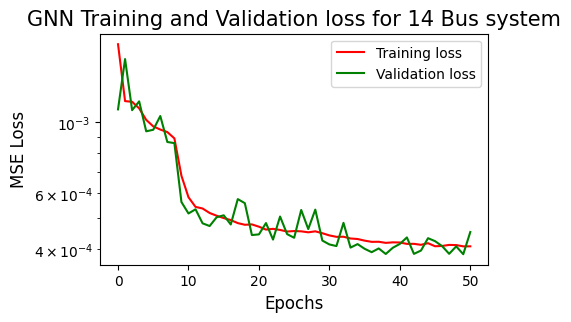

In [ ]:
trained_gnn_models = []


#create simple model instance
model = VanillaGNN(network_size=14, num_features=1, num_of_outputs=5)

#specify optimizer and other model details
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

training_losses = []
validation_losses = []
best_valid_loss = float('inf')
early_stop_thresh = 20
epochs = 50
best_epoch = -1

#Training loop
for epoch in range(epochs + 1):
    train_loss = train_gnn(model, train_loader, optimizer, device=device)
    valid_loss = evaluate_gnn(model, val_loader, device=device)
    training_losses.append(train_loss)
    validation_losses.append(valid_loss)

    scheduler.step(valid_loss)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

trained_gnn_models.append(model)  #Append the trained model

#Plot training progress (optional)
training_losses = np.array(training_losses)
validation_losses = np.array(validation_losses)

plt.subplots(figsize=(5, 3))
plt.plot([i for i in range(len(training_losses))], training_losses, 'r', label='Training loss')
plt.plot([i for i in range(len(validation_losses))], validation_losses, 'g', label='Validation loss')
plt.legend()
plt.title(f'GNN Training and Validation loss for 14 Bus system', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.semilogy()
plt.show()  #Add plt.show() to display the plot

### 5. Understand predictions

To ensure the model is working as we would expect, perform the following sanity checks:

### Task 5

1.   Finally for the GNN model, check how well the power balance constraint is satisfied by computing the maximum and mean power balance mismatches
2.   Plot the error distribution and comment on the type of distribution



Maximum Power Balance Mismatch: 36.93223571777344
Mean Power Balance Mismatch: 29.72326642560783


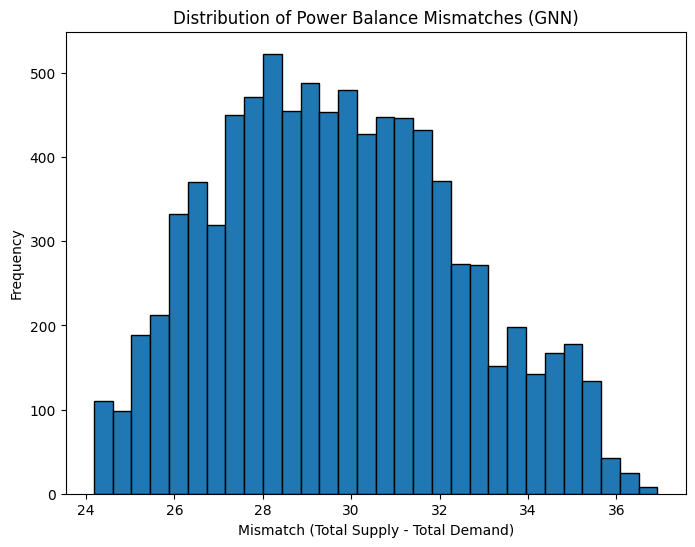

In [ ]:
#1)Maximum and mean power balance mismatches
mismatches = []
for batch in test_loader:  #Iterate through the test data
    x = batch.x.reshape(-1, 14).to(device)  # Reshape to (batch_size, num_features)
    y_pred = model(batch.to(device))  # Get model predictions

    total_demand = torch.sum(x, dim=1)
    total_supply = torch.sum(y_pred, dim=0)
    mismatch = total_supply - total_demand
    mismatches.extend(mismatch.tolist())  # Collect mismatches

#Calculate maximum and mean mismatch
max_mismatch = max(abs(m) for m in mismatches)
mean_mismatch = np.mean(mismatches)

print(f"Maximum Power Balance Mismatch: {max_mismatch}")
print(f"Mean Power Balance Mismatch: {mean_mismatch}")

#2)Plotting the mismatches
plt.figure(figsize=(8, 6))
plt.hist(mismatches, bins=30, edgecolor='black')
plt.title('Distribution of Power Balance Mismatches (GNN)')
plt.xlabel('Mismatch (Total Supply - Total Demand)')
plt.ylabel('Frequency')
plt.show()

Comment: The resulting is a normal distribution

### 6. Compare models

Compare the best FNN model from the previous section to the GNN model here based on the number of parameters the models have. Use the function provided below

In [ ]:
#count the number of parameters in a model
def count_model_parameters(model):
  tot_params = 0
  for parameter in model.parameters():
      layer_ws = 1
      for val in parameter.shape:
          layer_ws*=val
      tot_params += layer_ws
  print(f"Total number of parameters = {tot_params}")

### Task 6
Which of the two models is more parameter efficient?

In [ ]:
#Get the number of parameters for the GNN model
gnn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

#Access to the last trained physics-informed model
physics_params = sum(p.numel() for p in trained_models_with_physics[-1].parameters() if p.requires_grad)

print("GNN Model Parameters:", gnn_params)
print("Physics-informed Training Model Parameters:", physics_params)

if gnn_params < physics_params:
    print("\nThe GNN model is more parameter-efficient.")
else:
    print("\nThe Physics-informed training model is more parameter-efficient.")

GNN Model Parameters: 122565
Physics-informed Training Model Parameters: 9605

The Physics-informed training model is more parameter-efficient.


# END